In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from jax import jacobian
from jax.experimental.ode import odeint
import jax.numpy as jnp

from dask.distributed import Client

import lotka_volterra
import utils.caching
from utils.caching import make_cached
from utils.parallel import apply_along_axis_parallel, get_map_parallel, parallelise_for_unique, get_map_parallel_joblib
from utils.paths import GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

Directory where results of expensive calculations will be stored:

In [5]:
cached = make_cached(GENERATED_DATA_PATH)

We create a Dask client in order to parallelise calculations where possible:

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

Read-only input datasets:

In [7]:
@cached(item_type=np.ndarray, batch_size=lotka_volterra.n_chains, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [8]:
@cached(item_type=np.ndarray, batch_size=lotka_volterra.n_chains, read_only=True)
def hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

# Sensitivity analysis

Parameters of the Lotka-Volterra model:

In [9]:
y = pd.read_csv(GENERATED_DATA_PATH / 'lotka_volterra_gaussian_noise.csv', index_col=0)
t = y.index.values
y = y[['u1', 'u2']].values

## Forward sensitivity equations

Given a system of ODEs of the form:
$$\frac{du_r}{dt} = F_q(t, u_1, \dots, u_q; x),\qquad r=1,\dots,q,$$
the sensitivities can be found by solving forward sensitivity equations (this is equation (35) in the Supplementary Material):
$$\frac{d}{dt}\left(\frac{\partial u_r}{\partial x_s}\right) = \frac{dF_r}{dx_s} + \sum_{l=1}^q \frac{\partial F_r}{\partial u_l} \frac{\partial u_l}{\partial x_s}$$
with initial conditions
$$\frac{\partial u_r}{\partial x_s}(0) = 0.$$

For the Lotka-Volterra model, the forward sensitivity equations are:
$$\begin{split}
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_1}\right) &= u_1 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_1} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_2}\right) &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_2} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_3}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_3} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_4}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_4} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_4}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_1}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_1} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_2}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_2} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_3}\right) &= -u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_3} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_4}\right) &= u_1 u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_4} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_4}. \\
\end{split}$$

Denoting $w_1 = \frac{\partial u_1}{\partial \theta_1}$, $w_2 = \frac{\partial u_1}{\partial \theta_2}$, $w_3 = \frac{\partial u_1}{\partial \theta_3}$, $w_4 = \frac{\partial u_1}{\partial \theta_4}$ and $w_5 = \frac{\partial u_2}{\partial \theta_1}$, $w_6 = \frac{\partial u_2}{\partial \theta_2}$, $w_7 = \frac{\partial u_2}{\partial \theta_3}$, $w_8 = \frac{\partial u_2}{\partial \theta_4}$, we have the following additional equations:
$$\begin{split}
\frac{dw_1}{dt} &= u_1 + (\theta_1 - \theta_2 u_2) w_1 - \theta_2 u_1 w_5, \\
\frac{dw_2}{dt} &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) w_2 - \theta_2 u_1 w_6, \\
\frac{dw_3}{dt} &= (\theta_1 - \theta_2 u_2) w_3 - \theta_2 u_1 w_7, \\
\frac{dw_4}{dt} &= (\theta_1 - \theta_2 u_2) w_4 - \theta_2 u_1 w_8, \\
\frac{dw_5}{dt} &= \theta_4 u_2 w_1 + (\theta_4 u_1 - \theta_3) w_5, \\
\frac{dw_6}{dt} &= \theta_4 u_2 w_2 + (\theta_4 u_1 - \theta_3) w_6, \\
\frac{dw_7}{dt} &= -u_2 + \theta_4 u_2 w_3 + (\theta_4 u_1 - \theta_3) w_7, \\
\frac{dw_8}{dt} &= u_1 u_2 + \theta_4 u_2 w_4 + (\theta_4 u_1 - \theta_3) w_8. \\
\end{split}$$

In [10]:
def lotka_volterra_sensitivity(t, uw, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2, w1, w2, w3, w4, w5, w6, w7, w8 = uw
    return [
        # model equations
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
        # sensitivities
        u1 + (theta1 - theta2 * u2) * w1 - theta2 * u1 * w5,
        -u1 * u2 + (theta1 - theta2 * u2) * w2 - theta2 * u1 * w6,
        (theta1 - theta2 * u2) * w3 - theta2 * u1 * w7,
        (theta1 - theta2 * u2) * w4 - theta2 * u1 * w8,
        theta4 * u2 * w1 + (theta4 * u1 - theta3) * w5,
        theta4 * u2 * w2 + (theta4 * u1 - theta3) * w6,
        -u2 + theta4 * u2 * w3 + (theta4 * u1 - theta3) * w7,
        u1 * u2 + theta4 * u2 * w4 + (theta4 * u1 - theta3) * w8,
    ]

In [11]:
uw_init = np.concatenate([np.array(lotka_volterra.u_init), np.zeros(lotka_volterra.d * lotka_volterra.q)])

In [12]:
%%time
sol = solve_ivp(lotka_volterra_sensitivity, lotka_volterra.t_span, uw_init, args=(lotka_volterra.theta,), dense_output=True)
sensitivity_forward = sol.sol(t).T

CPU times: user 9.15 ms, sys: 7.26 ms, total: 16.4 ms
Wall time: 14.2 ms


Plot the solution again:

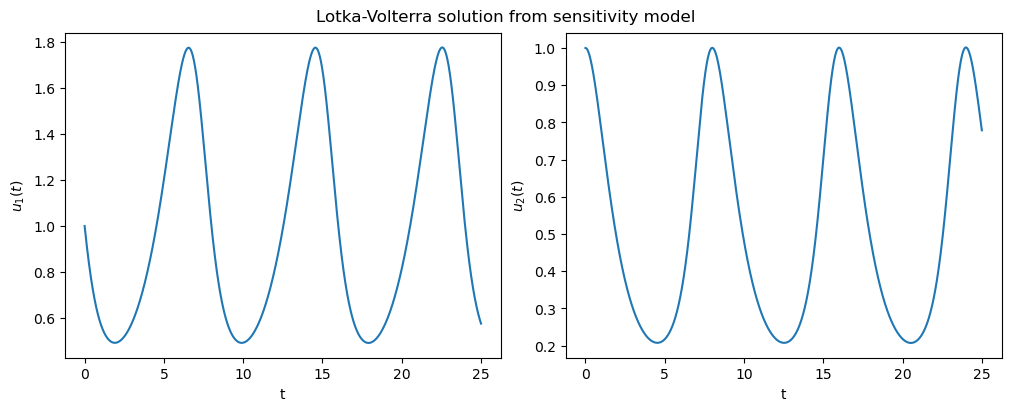

In [13]:
fig, axs = plt.subplots(1, lotka_volterra.q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model');
for i in range(lotka_volterra.q):
    axs[i].plot(t, sensitivity_forward[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Plot the sensitivities:

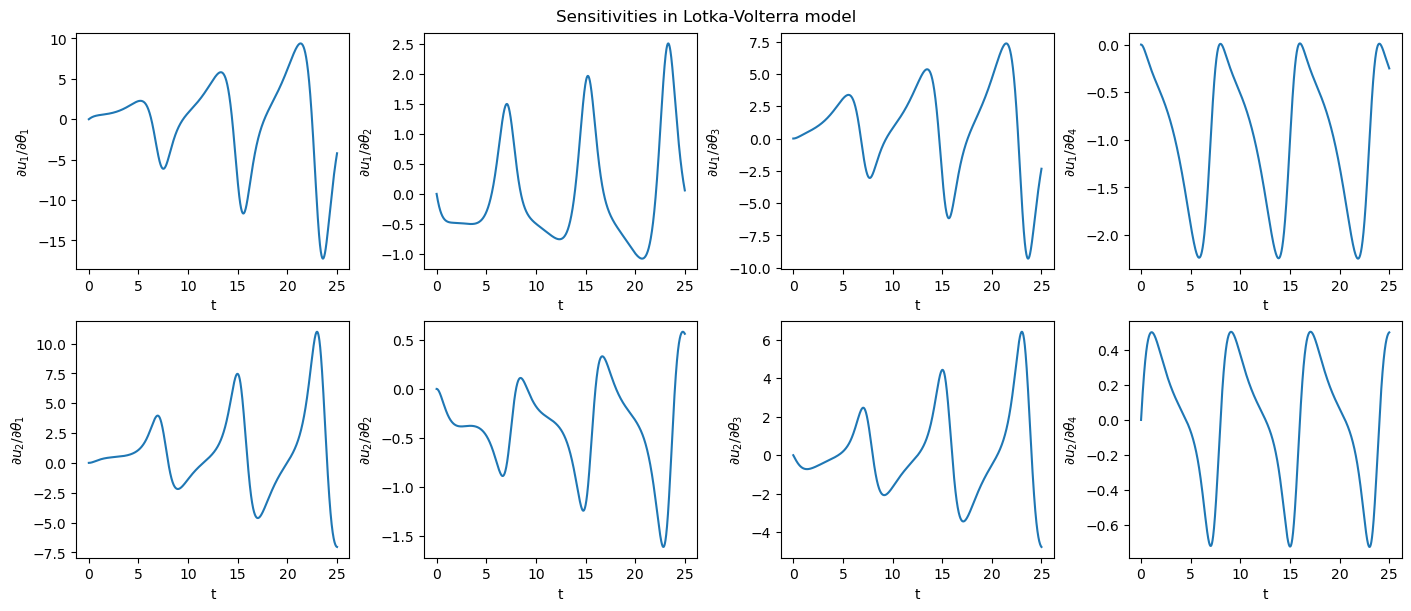

In [14]:
fig, axs = plt.subplots(lotka_volterra.q, lotka_volterra.d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Sensitivities in Lotka-Volterra model');
for i in range(lotka_volterra.q):
    for j in range(lotka_volterra.d):
        axs[i][j].plot(t, sensitivity_forward[:, lotka_volterra.q + i * lotka_volterra.d + j]);
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');

## Numerical Jacobian calculation

We need to redefine the function since ``jax.experimental.ode.odeint`` passes the state variable in the first argument and time in the second argument:

In [15]:
def lotka_volterra2(u, t, theta):
    return [
        theta[0] * u[0] - theta[1] * u[0] * u[1],
        theta[3] * u[0] * u[1] - theta[2] * u[1],
    ]

In [16]:
def solve_lotka_volterra2(theta):
    return odeint(lotka_volterra2, jnp.array(lotka_volterra.u_init), jnp.array(t), jnp.array(theta))

In [17]:
sol2 = solve_lotka_volterra2(lotka_volterra.theta)

Plot the solution first:

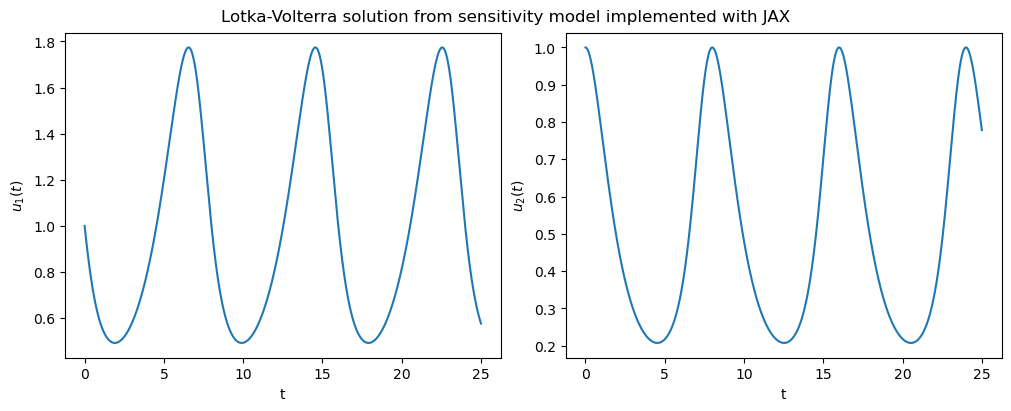

In [18]:
fig, axs = plt.subplots(1, lotka_volterra.q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model implemented with JAX');
for i in range(lotka_volterra.q):
    axs[i].plot(t, sol2[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Calculate the sensitivities:

In [19]:
@cached()
def sensitivity_jax() -> np.ndarray:
    return np.stack(jacobian(solve_lotka_volterra2)(lotka_volterra.theta))

We confirm that the numerical method agrees with the results from forward sensitivity equations:

DEBUG:utils.caching:Reading from disk cache: sensitivity_jax
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/sensitivity_jax.npy


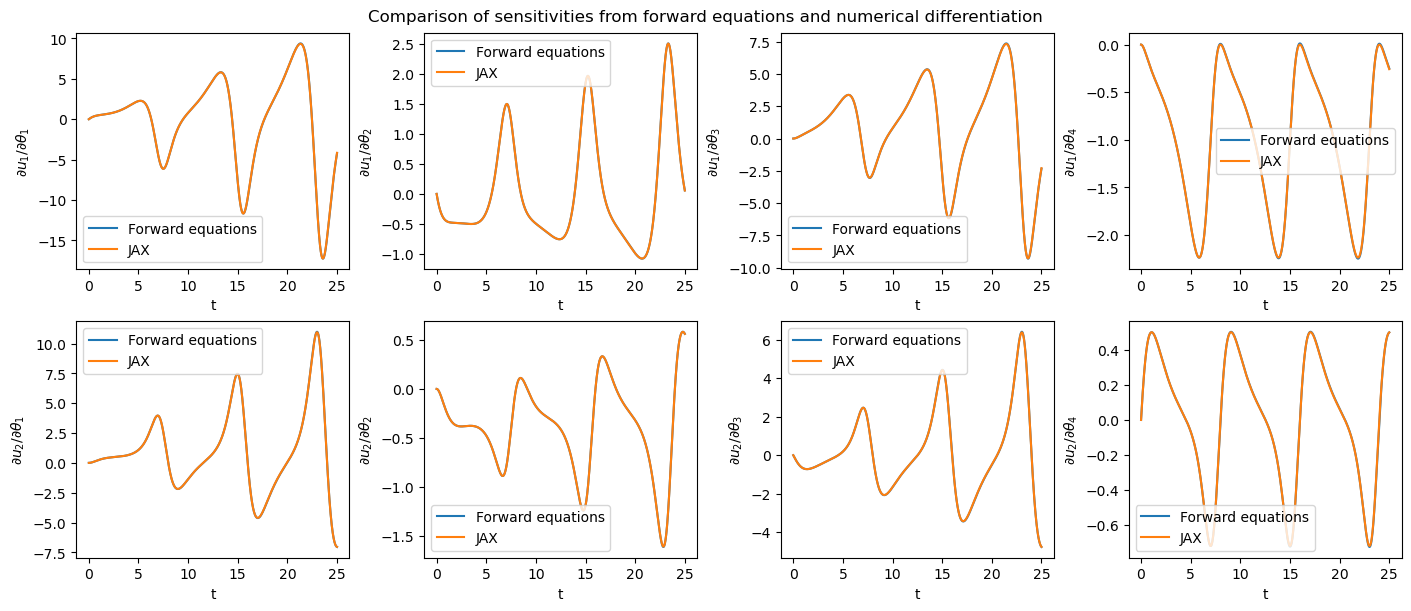

In [20]:
fig, axs = plt.subplots(lotka_volterra.q, lotka_volterra.d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Comparison of sensitivities from forward equations and numerical differentiation');
for i in range(lotka_volterra.q):
    for j in range(lotka_volterra.d):
        axs[i][j].plot(t, sensitivity_forward[:, 2 + i * lotka_volterra.d + j], label='Forward equations');
        axs[i][j].plot(t, sensitivity_jax()[j, :, i], label='JAX');
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');
        axs[i][j].legend();

## Calculating the gradient of the log-posterior

The Stein Thinning methog requires the gradient of the log-posterior $\nabla \log p$ as input. Below we follow section S3 of the Supplementary Material to derive it.

Since $p(\pmb{\theta}) \propto \mathcal{L}(\pmb{\theta}) \pi(\pmb{\theta})$, we have 
$$\nabla_{\pmb{\theta}} \log p(\pmb{\theta}) = \nabla_{\pmb{\theta}} \log \mathcal{L}(\pmb{\theta}) + \nabla_{\pmb{\theta}} \log \pi(\pmb{\theta}).$$
Assuming independent errors in observations yields
$$\mathcal{L}(\pmb{\theta}) = \prod_{i=1}^N \phi_i(u(t_i)),$$
and thus 
$$
\frac{\partial}{\partial \theta_s} \log \mathcal{L}(\pmb{\theta}) 
= \sum_{i=1}^N \frac{\partial}{\partial \theta_s} \log \phi_i(u(t_i))
= \sum_{i=1}^N \sum_{r=1}^q \frac{\partial}{\partial u_r} (\log \phi_i) \frac{\partial u_r}{\partial \theta_s},
$$
which can be written in matrix notation as
$$(\nabla_{\pmb{\theta}} \log \mathcal{L})(\pmb{\theta}) = \sum_{i=1}^N \left(\frac{\partial \mathbf{u}}{\partial \pmb{\theta}}\right)^T\! (t_i)\, (\nabla_u \log \phi_i)(u(t_i)),$$
where
$$\left(\frac{\partial \mathbf{u}}{\partial \pmb{\theta}}\right)_{r,s} = \frac{\partial u_r}{\partial \theta_s}$$
is the matrix of sensitivities, as obtained earlier.

Note that this does not match the expression provided on page 16 of the Supplementary Material:
$$(\nabla \log \mathcal{L})(x) = -\sum_{i=1}^N \frac{\partial u}{\partial x}(t_i) (\nabla \log \phi_i)(u(t_i)),$$
where the Jacobian is not transposed and there is a minus sign in front of the expression.

For a multivariate normal distribution of the errors:
$$\phi_i(u(t_i)) \propto \exp\left( -\frac{1}{2} (y_i - u(t_i))^T C^{-1} (y_i - u(t_i)) \right)$$
we obtain
$$(\nabla_u \log \phi_i)(u(t_i)) = C^{-1}(y_i - u(t_i)).$$

We assume independent standard normal priors for all components $\xi_i = \log \theta_i$, therefore
$$\pi(\pmb{\theta}) = \prod_{i=1}^d \pi_i(\log \theta_i) \propto \exp\left(-\frac{1}{2}\sum_{i=1}^d (\log \theta_i)^2\right)$$
and
$$\nabla_{\pmb{\theta}} \log \pi(\pmb{\theta}) = -\frac{\log \pmb{\theta}}{\pmb{\theta}},$$
where both the logarithm and division are performed component-wise.

We calculate the gradient of the log-likelihood from the Jacobian obtained previosly:

In [21]:
# reshape the Jacobian so it can be multiplied by the gradient of log phi
J = sensitivity_forward[:, lotka_volterra.q:].reshape(len(t), -1, lotka_volterra.q, order='F')
J.shape

(2400, 4, 2)

In [22]:
# calculate the gradient of log phi and reshape it
grad_log_phi = (inv(lotka_volterra.C) @ (y - sensitivity_forward[:, :lotka_volterra.q]).T).T[:, :, np.newaxis]
grad_log_phi.shape

(2400, 2, 1)

In [23]:
grad_log_lik = np.sum(np.squeeze(J @ grad_log_phi), axis=0)
grad_log_lik

array([ 909.82835706, -161.34819546,  313.24871811,   71.01053051])

Now put the calculation into a function so we can use it later:

In [24]:
def grad_log_likelihood(theta):
    """Solve the system of ODEs and calculate the log-likelihood"""
    sol = solve_ivp(lotka_volterra_sensitivity, lotka_volterra.t_span, uw_init, args=(theta,), dense_output=True)
    sensitivity_forward = sol.sol(t).T
    J = sensitivity_forward[:, lotka_volterra.q:].reshape(len(t), -1, lotka_volterra.q, order='F')
    grad_log_phi = (inv(lotka_volterra.C) @ (y - sensitivity_forward[:, :lotka_volterra.q]).T).T[:, :, np.newaxis]
    return np.sum(np.squeeze(J @ grad_log_phi), axis=0)

In [25]:
%%time
grad_log_likelihood(lotka_volterra.theta)

CPU times: user 10.3 ms, sys: 3.79 ms, total: 14.1 ms
Wall time: 17.3 ms


array([ 909.82835706, -161.34819546,  313.24871811,   71.01053051])

We check the numbers against the numerical gradient:

In [26]:
def grad_log_likelihood_jax(theta):
    import jax.scipy.stats as jstats
    def log_likelihood(theta):
        sol = odeint(lotka_volterra2, jnp.array(lotka_volterra.u_init), jnp.array(t), jnp.array(theta))
        return jnp.sum(
            jstats.multivariate_normal.logpdf(
                jnp.array(y) - sol,
                mean=jnp.array(lotka_volterra.means),
                cov=jnp.array(lotka_volterra.C)
            )
        )
    return jacobian(log_likelihood)(theta)

In [27]:
%%time
grad_log_likelihood_jax(lotka_volterra.theta)

CPU times: user 2.93 s, sys: 67.4 ms, total: 3 s
Wall time: 2.88 s


[Array(872.4996, dtype=float32, weak_type=True),
 Array(-144.05223, dtype=float32, weak_type=True),
 Array(307.3599, dtype=float32, weak_type=True),
 Array(64.18586, dtype=float32, weak_type=True)]

We use the gradient calculation based on solving forward sensitivity equations in what follows.

In [28]:
def grad_log_posterior(theta):
    return grad_log_likelihood(theta) - np.log(theta) / theta

In [29]:
grad_log_posterior(lotka_volterra.theta)

array([ 910.42608477, -161.56261572,  313.24871811,   71.01053051])

## Parallel calculation of gradients

We note that calculating gradients after a MCMC run is what is called "embarrassingly parallelisable" and the time required for this step can be effectively eliminated given sufficient computational resources. This is in contrast to the MCMC run itself, which is inherently sequential.

Here we demonstrate how the popular package ``Dask`` can be used to parallelise this computation across cores of a local machine.

See the notebook in ``examples/Dask_AWS.ipynb`` for a comparison between sequential calculation, parallel computation locally and on AWS.

We can save time by calculating the gradients for unique samples only:

Calculate the gradients for the random-walk samples:

In [30]:
@cached(batch_size=len(lotka_volterra.theta_inits))
def rw_grads(i: int) -> np.ndarray:
    return parallelise_for_unique(grad_log_posterior, np.exp(rw_samples[i]), map_parallel)

In [31]:
[rw_grads(i) for i in range(lotka_volterra.n_chains)];

DEBUG:utils.caching:Reading from disk cache: rw_grads_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_grads_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_grads_1
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_grads_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_grads_2
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_grads_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_grads_3
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_grads_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_grads_4
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/rw_grads_4.npy


Calculate the gradients for HMC samples:

In [32]:
@cached(batch_size=len(lotka_volterra.theta_inits))
def hmc_grads(i: int) -> np.ndarray:
    return parallelise_for_unique(grad_log_posterior, np.exp(hmc_samples[i]), map_parallel)

In [33]:
[hmc_grads(i) for i in range(lotka_volterra.n_chains)];

DEBUG:utils.caching:Reading from disk cache: hmc_grads_0
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/hmc_grads_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_grads_1
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/hmc_grads_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_grads_2
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/hmc_grads_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_grads_3
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/hmc_grads_3.npy
DEBUG:utils.caching:Reading from disk cache: hmc_grads_4
DEBUG:utils.caching:Reading /home/ec2-user/SageMaker/gradient-free-mcmc-postprocessing/data/generated/hmc_grads_4.npy
